In [4]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 122.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 112.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.5 MB/s eta 0:00:00


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<ipython-input-5-a67f4e39aa93>:25: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.4394 - loss: 1.8491 - val_accuracy: 0.5979 - val_loss: 1.3019
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6050 - loss: 1.2659 - val_accuracy: 0.6388 - val_loss: 1.1406
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6389 - loss: 1.1300 - val_accuracy: 0.6528 - val_loss: 1.0739
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6448 - loss: 1.0845 - val_accuracy: 0.6605 - val_loss: 1.0375
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6542 - loss: 1.0477 - val_accuracy: 0.6642 - val_loss: 1.0150
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6594 - loss: 1.0212 - val_accuracy: 0.6674 - val_loss: 1.0002
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.6589 - loss: 1.0203 - val_accuracy: 0.6687 - val_loss: 0.9903
Epoch 8/10
1500/1500 ━━━━━━

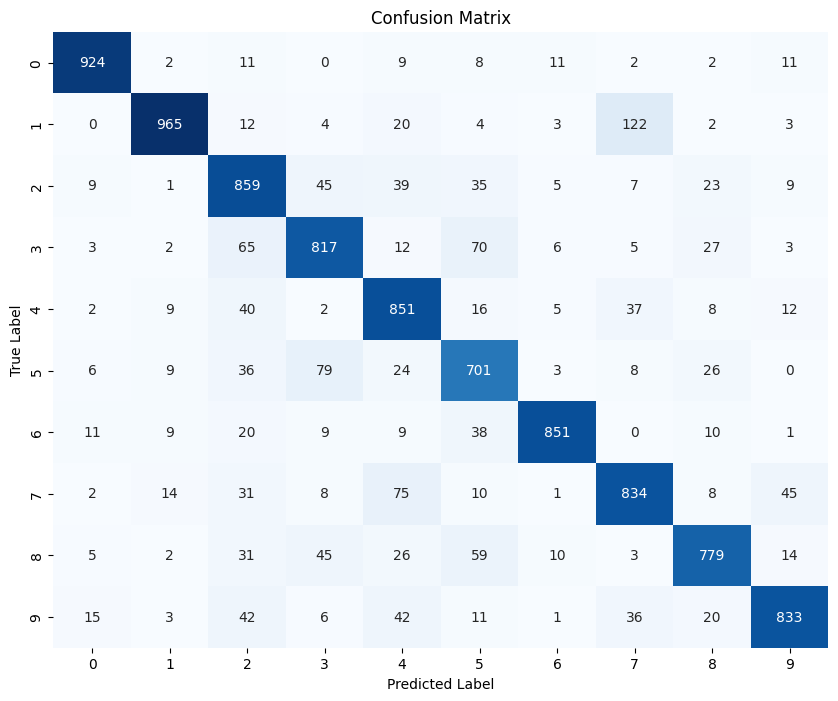

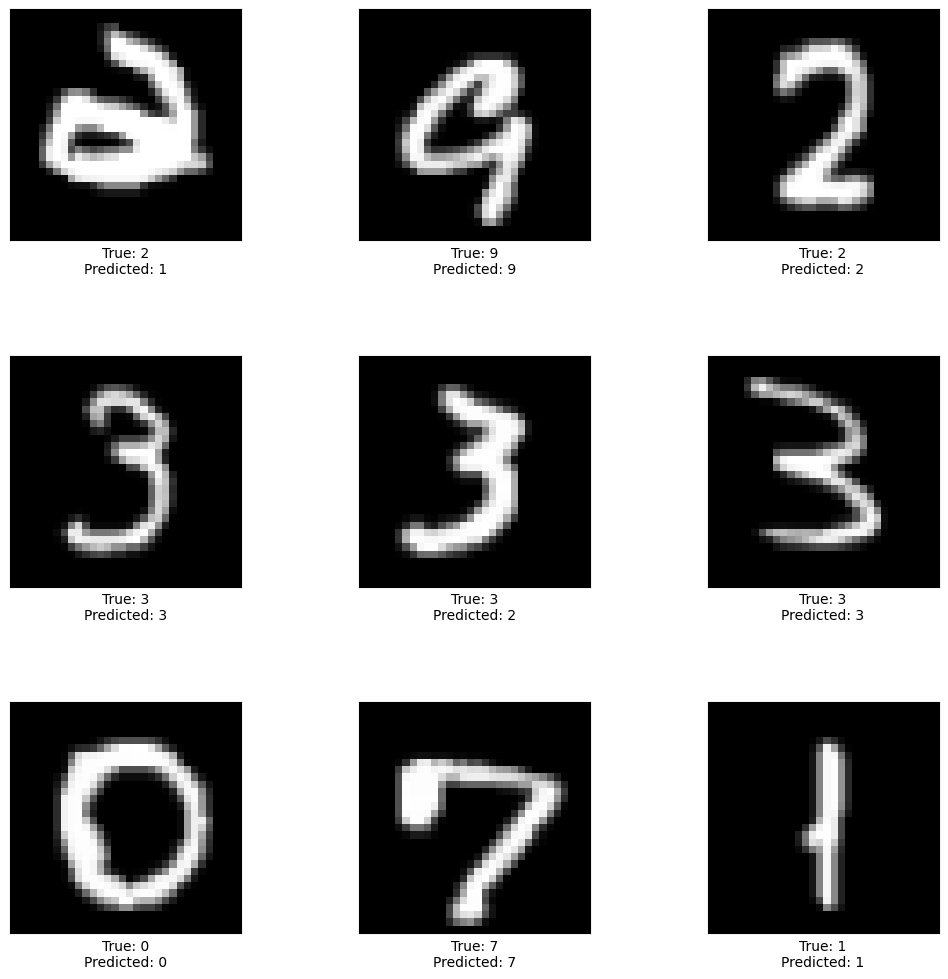

In [5]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, Lambda, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST data
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Preprocess the data: Reshape and scale
train_images = np.stack([train_images]*3, axis=-1) / 255.0
test_images = np.stack([test_images]*3, axis=-1) / 255.0

# Resize images to 32x32 to match the input size of MobileNetV2
train_images = tf.image.resize(train_images, [32, 32])
test_images = tf.image.resize(test_images, [32, 32])

# Convert labels to one-hot encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Load the MobileNetV2 model, pre-trained on ImageNet
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
base_model.trainable = False

# Create new model on top
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
outputs = Dense(10, activation='softmax')(x)
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_split=0.2)

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile the model (necessary for the changes to take effect)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower lr for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
model.fit(train_images, train_labels, epochs=5, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_images, test_labels)

print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the values from the test dataset
test_predictions = model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_true_classes, test_predictions_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

def display_sample(sample_images, sample_labels, sample_predictions):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].reshape(32, 32), cmap='gray')  # Change to 32x32
        ax.set_xlabel(f"True: {sample_labels[i]}\nPredicted: {sample_predictions[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Convert RGB to Grayscale for visualization; this assumes the images were resized to 32x32
test_images_gray = np.dot(test_images[...,:3], [0.2989, 0.5870, 0.1140])

# Selecting a few images from the test set
random_indices = np.random.choice(len(test_images_gray), 9, replace=False)
sample_images = test_images_gray[random_indices]
sample_labels = test_true_classes[random_indices]
sample_predictions = test_predictions_classes[random_indices]

# Display the selected images and their labels
display_sample(sample_images, sample_labels, sample_predictions)